In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
from tqdm import tqdm
import random
plt.style.use('ggplot')
import pickle
from sklearn import tree
from sklearn.tree import export_graphviz
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.impute import SimpleImputer
from scipy import interpolate
from scipy.interpolate import interp1d


In [2]:
MAX_DEPTH=6
NUMESTIMATORS=2

In [3]:
def getAuc(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit,class_weight='balanced'),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        #print(X_test,y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        if VERBOSE:
            print(auc)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    hull = ConvexHull(points)
    x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    return auc,CLASSIFIERS


def saveFIG(filename='tmp.pdf',AXIS=False):
    '''
        save fig for publication
    '''
    import pylab as plt
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    if not AXIS:
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(filename,dpi=300, bbox_inches = 'tight',
                pad_inches = 0,transparent=False) 
    return

In [4]:
def getacc(c1,c2,p1,p2,p3,f1,f2):
    s1=f1(1-c1)
    s2=f2(1-c2)
    A=(c1*c2*(1-p1)*(1-p2))/((c1*(1-p1)+(1-s1)*p1)*(c2*(1-p2)+(1-s2)*p2))
    B=(1-s1)*p1 - (1-c1)*(1-p1) + (1-s2)*p2 - (1-c2)*(1-p2) + p3
    return s1*p1+s2*p2+ A*B

In [5]:
def getCoverage(model,verbose=True):
    '''
        return how many distinct items (questions)
        are used in the model set.
        This includes the set of questions being
        covered by all forms that may be 
        generated by the model set
    '''
    FS=[]
    for m in model:
        for count in range(len(m.estimators_)):
            clf=m.estimators_[count]
            fs=clf.tree_.feature[clf.tree_.feature>0]
            FS=np.array(list(set(np.append(FS,fs))))
    if verbose:
        print("Number of items used: ", FS.size)
    return FS

def getConfusion(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,CONFUSION={},VERBOSE=False, USE_ONLY=None,target_names = None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators,class_weight='balanced',
                                       max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators,class_weight='balanced',
                                     max_depth=max_depth,min_samples_split=minsplit),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        print(y_test,y_pred)
        cmat=confusion_matrix(y_test, y_pred)
        acc=accuracy_score(y_test, y_pred)
        
        CONFUSION[clf]=cmat
        
        if VERBOSE:
            print(classification_report(y_test, y_pred, target_names=target_names))
            print('Confusion MAtrix:\n', cmat)
            print(' ')
            print('Accuracy:', acc)

        
    return CONFUSION,acc,y_test,y_pred

In [6]:
def getFmap(CLFstar,X,y):
    auc_=[]
    ROC={}
    fpr_ = np.linspace(0, 1, num=20, endpoint=True)
    for run in np.arange(1000):
        clf=CLFstar
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        y_pred=clf.predict_proba(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        f = interp1d(fpr, tpr)
        auc_=np.append(auc_,metrics.auc(fpr_, f(fpr_)))
        ROC[metrics.auc(fpr, tpr)]={'fpr':fpr_,'tpr':f(fpr_)}

    TPR=[]
    for a in ROC.keys():
        TPR=np.append(TPR,ROC[a]['tpr'])
    TPR=TPR.reshape(int(len(TPR)/len(fpr_)),len(fpr_))
    medTPR=np.median(TPR,axis=0)
    return interpolate.interp1d(fpr_,np.median(TPR,axis=0) )

In [7]:
xf=pd.read_csv('./2022summer/adeptphase2/Cognition.csv',index_col=0)
xf.index.name='subject_id'
df=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
df=df.join(xf)#.head()

In [8]:
#df=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
df.head()

,Biotype,project,panss_p1,panss_p2,panss_p3,panss_p4,panss_p5,panss_p6,panss_p7,panss_n1,...,BACS_Tower_z_within_imputed,ConsensusWRAT,Pro_NoGap_within_Impute_Age_Sex_adjusted,Pro_Gap_within_Impute_Age_Sex_adjusted,Pro_Overlap_within_Impute_Age_Sex_adjusted,Anti_Corr_Lat_within_Impute_Age_Sex_adjusted,Anti_Error_Lat_within_Impute_Age_Sex_adjusted,Anti_prop_error_within_Impute_Age_Sex_adjusted,SSGoDiff_standwithin,SSTProportionError_standwithin
subject_id,,,,,,,,,,,,,,,,,,,,,
1,2,1,4.0,3.0,4.0,1.0,3.0,2.0,1.0,4.0,...,-2.668861,103.0,1.29400,1.250300,1.365000,1.49310,1.84340,0.177350,-0.086522,-0.908397
4,3,1,3.0,1.0,3.0,1.0,2.0,2.0,1.0,3.0,...,-0.117295,125.0,-0.81433,-0.067136,-0.717420,-0.16308,-0.45067,0.751960,0.406882,-0.055350
17,2,1,2.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,...,0.132828,105.0,-0.79924,-1.156300,-0.846560,-1.18750,-0.90979,2.088300,-1.289105,1.082046
53,2,1,4.0,3.0,5.0,2.0,1.0,3.0,1.0,5.0,...,-1.243126,84.0,0.71209,1.625000,1.195700,3.12500,0.18100,0.029824,-1.082237,1.224220
73,2,1,6.0,5.0,6.0,4.0,5.0,6.0,6.0,1.0,...,-0.077277,93.0,-1.70400,-1.294200,-0.096217,0.25845,-1.65310,0.617100,-2.243046,2.645965


In [9]:
#df=df[df['Biotype']==3]
df=df.dropna()
df0=df
[p1,p2,p3]=(df0.Biotype.value_counts()/df0.Biotype.value_counts().sum()).values

In [10]:
df.Biotype.value_counts()
# 3 is HC

3    397
1    348
2    307
Name: Biotype, dtype: int64

In [11]:
def getRES(df0,MAX_DEPTH=6,NUMESTIMATORS=2):
    df=df0
    X=df.iloc[:,2:].values
    y=df.Biotype.values#.astype(str)
    y=[(int(x)==2)+0 for x in y ]

    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarA=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f1=getFmap(CLFstarA,X,y)


    #df=df0[df0.Biotype.isin([1,5])]
    df=df0
    X=df.iloc[:,2:].values
    y=df.Biotype.values#.astype(str)
    y=[(int(x)==3)+0 for x in y ]

    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarB=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f2=getFmap(CLFstarB,X,y)

    R=[]
    for i in np.arange(.7,.99,.01):
        for j in np.arange(.7,.99,.01):
            R=np.append(R,[i,j,getacc(i,j,p1,p2,p3,f1,f2)])
    R=pd.DataFrame(R.reshape(len(R)//3,3))
    R.columns=['c1','c2','acc']
    R['s1']=f1(1-R.c1)
    R['s2']=f2(1-R.c2)


    X_test=df.values.astype(np.float32)
    L=[]

    for sample_id in np.arange(len(X_test)):
        Node_index=[]
        for i in CLFstarA.estimators_:
            threshold= i.tree_.threshold
            feature= i.tree_.feature
            node_indicator = i.tree_.decision_path(X_test)
            leaf_id = i.tree_.apply(X_test)

            node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]
            Node_index=np.append(Node_index,node_index)

        for i in CLFstarB.estimators_:
            threshold= i.tree_.threshold
            feature= i.tree_.feature
            node_indicator = i.tree_.decision_path(X_test)
            leaf_id = i.tree_.apply(X_test)

            node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]
            Node_index=np.append(Node_index,node_index)
        L=np.append(L,len(set(Node_index))-2)
    L=np.array(L)
    #print(np.mean(L),np.median(L))
    #sns.displot(L);


    RES=R.sort_values('acc',ascending=False).head(1)
    RES['nq_mean']=np.mean(L)
    RES['nq_median']=np.median(L)
    return RES

In [12]:
Rs=getRES(df0,MAX_DEPTH=10)
Rs

,c1,c2,acc,s1,s2,nq_mean,nq_median
654,0.91,0.94,0.835307,0.815109,0.778962,27.320342,27.0


In [13]:
CF=np.zeros([3,3])
s2=Rs.s1.values[0]
s3=Rs.s2.values[0]
c2=Rs.c1.values[0]
c3=Rs.c2.values[0]
CF=[[c2*c3,1-c2,c2*(1-c3)],[(1-s2)*(1-s3),s2,(1-s2)*s3],[c2*(1-s3),1-c2,c2*s3]]

CF=pd.DataFrame(CF,columns=['B1','B2','B3'])
CF.index=CF.columns
CF

,B1,B2,B3
B1,0.855400,0.090000,0.054600
B2,0.040868,0.815109,0.144023
B3,0.201145,0.090000,0.708855


In [14]:
RES=pd.concat([pd.concat([getRES(df0,MAX_DEPTH=m) for m in tqdm(np.arange(6,12))]) for run in tqdm(range(20))])

  0%|                                                     | 0/6 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 20/20 [19:57<00:00, 59.89s/it]


In [15]:
RES

,c1,c2,acc,s1,s2,nq_mean,nq_median
444,0.84,0.94,0.688357,0.660147,0.460083,19.865970,20.0
589,0.89,0.89,0.726158,0.554013,0.746212,19.078897,19.0
709,0.93,0.89,0.764480,0.607077,0.765768,22.942966,23.0
620,0.90,0.90,0.785786,0.749043,0.746351,27.610266,28.0
743,0.94,0.93,0.827556,0.706084,0.818846,27.729087,28.0
...,...,...,...,...,...,...,...
444,0.84,0.94,0.741390,0.739680,0.589142,18.282319,19.0
619,0.90,0.89,0.788045,0.725624,0.810812,22.279468,23.0
624,0.90,0.94,0.801891,0.729295,0.744376,25.572243,26.0
742,0.94,0.92,0.816999,0.775002,0.715631,27.041825,27.0


<AxesSubplot:xlabel='nq_median'>

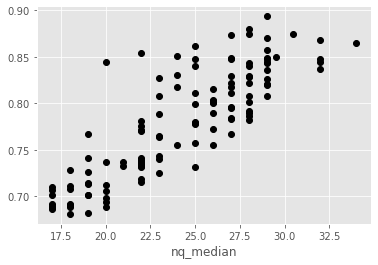

In [16]:
RES.set_index('nq_median').acc.plot(style='ko')

Text(0, 0.5, 'mean accuracy')

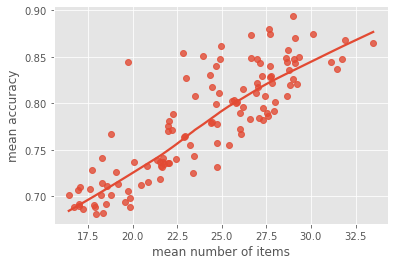

In [17]:
ax=sns.regplot(x=RES.nq_mean,y=RES.acc,ci=99.999,lowess=True)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')
#plt.savefig('accvsitemnumber.png',dpi=200,bbox_inches='tight',transparent=True)

/tmp/ipykernel_1650491/3830656434.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/3830656434.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/3830656434.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/3830656434.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/3830656434.py:21:

Text(0, 0.5, 'mean accuracy')

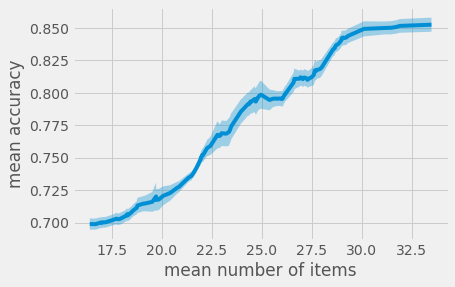

In [18]:
plt.style.use('fivethirtyeight')
df=pd.DataFrame(RES.set_index('nq_mean').acc)
import scipy.stats as stats
import statsmodels.api as sm
from scipy import interpolate
from scipy.interpolate import interp1d

lowess = sm.nonparametric.lowess
df.index=df.index.astype(float)
df=df.sort_index()
S=.2
RUNS=50
DF=df
   
for i in range(RUNS):
    X=df.sample(int(np.round(S*df.index.size))).sort_index().reset_index().values

    z = lowess(X[:,1], X[:,0], frac= .25)
    f = interp1d(z[:,0], z[:,1])
    Y=f(X[:,0])
    DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
DF=DF.interpolate(method='index',order=3,limit_direction='both')
STD=pd.DataFrame(2.62*(DF.std(axis=1)/np.sqrt(RUNS)))
Mf=pd.DataFrame(DF.mean(axis=1)).assign(sm=STD)
Mf.columns=['mn','sm']
ax=Mf.mn.plot()
plt.fill_between(Mf.index,Mf.mn-Mf.sm,Mf.mn+Mf.sm,alpha=.35)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')
#plt.savefig('accvsitemnumber1.png',dpi=200,bbox_inches='tight',transparent=True)

/tmp/ipykernel_1650491/2545937345.py:20: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/2545937345.py:20: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
/tmp/ipykernel_1650491/2545937345.py:20: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0'} in the result is deprecated and will raise a MergeError in a future version.
  DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))


Text(0, 0.5, 'mean accuracy')

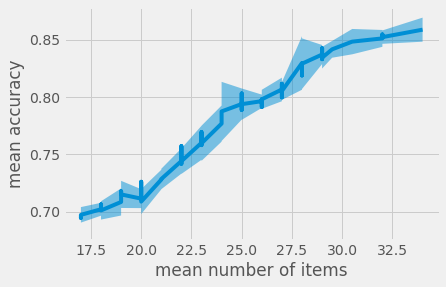

In [19]:
df=pd.DataFrame(RES.set_index('nq_median').acc)
import scipy.stats as stats
import statsmodels.api as sm
from scipy import interpolate
from scipy.interpolate import interp1d

lowess = sm.nonparametric.lowess
df.index=df.index.astype(float)
df=df.sort_index()
S=.3
RUNS=8
DF=df

for i in range(RUNS):
    X=df.sample(int(np.round(S*df.index.size))).sort_index().reset_index().values

    z = lowess(X[:,1], X[:,0], frac= .35)
    f = interp1d(z[:,0], z[:,1])
    Y=f(X[:,0])
    DF=DF.join(pd.DataFrame(Y,X[:,0]),rsuffix=str(i))
DF=DF.interpolate(method='index',order=3,limit_direction='both')
STD=pd.DataFrame(2.62*(DF.std(axis=1)/np.sqrt(RUNS)))
Mf=pd.DataFrame(DF.mean(axis=1)).assign(sm=STD)
Mf.columns=['mn','sm']
ax=Mf.mn.plot()
plt.fill_between(Mf.index,Mf.mn-Mf.sm,Mf.mn+Mf.sm,alpha=.5)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')


In [20]:
R=RES.sort_values('acc',ascending=False)['c1','c2','acc']

KeyError: ('c1', 'c2', 'acc')

In [ ]:
R_=R.pivot(index='c2',columns='c3')
R_

In [ ]:
ax=sns.heatmap(R_)
ax.set_xlabel('c-2vall')
ax.set_ylabel('c-3vall')

In [35]:
pos=plt.imshow(R_)
plt.colorbar(pos)

NameError: name 'R_' is not defined

In [ ]:
R_=R.pivot(index='c1',columns='c2')
R_.columns=[str(x[1])[:4] for x in R_.columns]
R_.index=[str(x)[:4] for x in R_.columns]

In [ ]:
getacc(.85,.8,p1,p2,p3,f1,f2)

In [ ]:
ACC=[]
CLFh={}
for run in tqdm(np.arange(500)):
    auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
               minsplit=2,VERBOSE=False, USE_ONLY=[2])
    ACC=np.append(ACC,auc)
    if auc > 0.5:
        CLFh[auc]=CLFS
CLFstarA=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
f1=getFmap(CLFstarA)


#df=df0[df0.Biotype.isin([1,5])]
df=df0
X=df.iloc[:,2:].values
y=df.Biotype.values#.astype(str)
y=[(int(x)==3)+0 for x in y ]

ACC=[]
CLFh={}
for run in tqdm(np.arange(500)):
    auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
               minsplit=2,VERBOSE=False, USE_ONLY=[2])
    ACC=np.append(ACC,auc)
    if auc > 0.5:
        CLFh[auc]=CLFS
CLFstarB=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
f2=getFmap(CLFstarB)

In [ ]:
f2=getFmap(CLFstarB)

In [ ]:
CLFstarB=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
#F=[]
#for i in CLFstar.estimators_:
#    F=np.append(F,i.tree_.feature)
#uF=np.array(list(set(list(F[F>0]))))
#len(uF)

In [ ]:
ACC=[]
CLFh={}
for run in tqdm(np.arange(500)):
    auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
               minsplit=2,VERBOSE=False, USE_ONLY=[2])
    ACC=np.append(ACC,auc)
    if auc > 0.5:
        CLFh[auc]=CLFS
sns.distplot(ACC)
np.median(ACC)

In [ ]:
#df=df0[df0.Biotype.isin([1,5])]
df=df0
X=df.iloc[:,2:].values
y=df.Biotype.values#.astype(str)
y=[(int(x)==3)+0 for x in y ]

In [ ]:
f1=getFmap(CLFstarA)

In [ ]:
CLFstarA=CLFh[np.array([k for k in CLFh.keys()]).max()][0]